In [1]:
import numpy as np
import pandas as pd
import nltk
import vaderSentiment as vd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from nrclex import NRCLex

In [3]:
from textblob import TextBlob
import random

In [4]:
#nltk.download()

In [5]:
data=pd.read_csv("0313_women.csv")
data.user_id.unique

<bound method Series.unique of 0        1.315573e+09
1        7.060000e+17
2        4.095700e+07
3        2.699554e+09
4        1.541238e+08
             ...     
17557    1.517497e+07
17558    4.679792e+08
17559    3.942779e+08
17560    7.991037e+08
17561    7.460000e+17
Name: user_id, Length: 17562, dtype: float64>

In [6]:
#random.seed(123)
#data=data.sample(n=25000)

#from langdetect import detect
#def detect_lang(text):
#    try:
#        lang = detect(text)
#    except:
#        lang = 'unknown'
#    return lang
# apply the function to each row in the DataFrame and filter out non-English rows
data = data[data['retweet_count']>0]
#data = data[data['retweet_count']<3057]
#data = data[data['country']=='United States of America']
data.shape

#data = data[data['user_id'] in unique]
data = data.drop_duplicates(subset = ['user_id'], keep = False)
data.shape

(3057, 28)

In [7]:
#data = data[data['tweet'].apply(detect_lang) == 'en'].sample(n=2000)
random.seed(123)
data = data.sample(n=3000)
print(data.head(3))
print(data.shape)

       Unnamed: 0           place                      created_at  \
3908         3909      Denton, TX  Sat Jan 21 18:57:54 +0000 2017   
11155       11156  Providence, RI  Sun Jan 22 14:34:37 +0000 2017   
5717         5718     La Mesa, CA  Sun Jan 22 06:48:43 +0000 2017   

                            hashtags  favorite_count            id lang  \
3908   WomensMarch womensmarchdenton               7  8.230000e+17   en   
11155                    WomensMarch               9  8.230000e+17   en   
5717                     WomensMarch               4  8.230000e+17   en   

       possibly_sensitive  retweet_count  \
3908                False              2   
11155               False              4   
5717                False              2   

                                                  source  ...  \
3908   <a href="http://twitter.com/download/iphone" r...  ...   
11155  <a href="http://tapbots.com/tweetbot" rel="nof...  ...   
5717   <a href="http://twitter.com/download/iphone

In [ ]:
sent_analyzer = SentimentIntensityAnalyzer()
sentence = 'hi'
score=sent_analyzer.polarity_scores(sentence)
print(score["compound"])
del score["compound"]
np.array(list(score.values()))


In [8]:
#add compound sentiment score to dataframe
#each entry of compound score include 'neg', 'neu', 'pos', each score ranges in [0,1]
#'compound' score in sequence from [-1,1], as initial opinion
#'compound' score as the user's initial opinion, as a separated new column
#data type as np array with 4 elements
compound_score = []
initial_opinion = []
sent_analyzer = SentimentIntensityAnalyzer()
for i in range(3000):
    sentence = data['text'].iloc[i]
    overall=sent_analyzer.polarity_scores(sentence)
    compound=overall["compound"]
    initial_opinion.append(compound)
    del overall["compound"]
    score=np.array(list(overall.values()))
    compound_score.append(score)

len(compound_score)
data['compound_score'] = compound_score
data['initial_opinion'] = initial_opinion
data.head(3)

#didn't find the buildin algorithm for calculating compound sentiment score
#Using the compound score can be enough to determine the underlying sentiment of a text, because for:
#a positive sentiment, compound ≥ 0.05
#a negative sentiment, compound ≤ -0.05
#a neutral sentiment, the compound is between [-0.05, 0.05]

,Unnamed: 0,place,created_at,hashtags,favorite_count,id,lang,possibly_sensitive,retweet_count,source,...,user_name,user_screen_name,user_statuses_count,user_verified,index,date,lat,lng,compound_score,initial_opinion
3908,3909,"Denton, TX",Sat Jan 21 18:57:54 +0000 2017,WomensMarch womensmarchdenton,7,8.230000e+17,en,False,2,"<a href=""http://twitter.com/download/iphone"" r...",...,Cinema Collection,CinemaCollectio,1041,False,32615,1/21/2017 18:57,33.2175,-97.1418,"[0.0, 0.588, 0.412]",0.6369
11155,11156,"Providence, RI",Sun Jan 22 14:34:37 +0000 2017,WomensMarch,9,8.230000e+17,en,False,4,"<a href=""http://tapbots.com/tweetbot"" rel=""nof...",...,Ray Sullivan,RaySullivan,11031,False,28495,1/22/2017 14:34,41.8230,-71.4187,"[0.0, 0.851, 0.149]",0.2732
5717,5718,"La Mesa, CA",Sun Jan 22 06:48:43 +0000 2017,WomensMarch,4,8.230000e+17,en,False,2,"<a href=""http://twitter.com/download/iphone"" r...",...,Jamie,JamisonBadger,6208,False,4609,1/22/2017 6:48,32.7703,-117.0204,"[0.0, 0.817, 0.183]",0.3551


In [9]:
#add sentiment score
#each entry is an np array of 8 elements, which are 'fear','anger','anticipation','trust','surprise','sadness','disgust','joy'
#each sentiment score ranges in {0,1,2,3,4}

#negative emotion can decrease trust

sentiment_score = []
conf_bound = []
keys_to_check = ['fear','anger','anticipation','trust','surprise','sadness','disgust','joy']

for i in range(3000):
    sentence = data['text'].iloc[i]
    text_object = NRCLex(sentence)
    score=text_object.raw_emotion_scores
    for key in keys_to_check:
        if key not in score:
            # add the missing key with a default value
            score[key] = 0
    new_score = {key: score[key] for key in keys_to_check if key in score}
    compound_score = data['compound_score'].iloc[i]
    pos = compound_score[2]
    neg = compound_score[0]
    
    conf_level = new_score['trust'] + pos*(new_score['anticipation']+new_score['surprise']+new_score['joy']) - neg*(new_score['fear']+new_score['anger']+new_score['sadness']+new_score['disgust'])
    conf_level = (conf_level+16)/16
    #4+1*(3*4)-0*(4)=16
    #0+0*(3)-1*(4*4)=-16
    #confidence level range from -16 to 16
    
    conf_bound.append(conf_level)
    new_score = np.array(list(new_score.values()))
    sentiment_score.append(new_score)

#print(len(sentiment_score))

data['sentiment_score'] = sentiment_score
data['conf_bound'] = conf_bound


print(np.percentile(data['conf_bound'], [0, 25, 50, 75, 100]))
data.tail(3)
#new range for confidence bound: 0 to 2

[0.7879375 1.        1.        1.0625    1.576625 ]


,Unnamed: 0,place,created_at,hashtags,favorite_count,id,lang,possibly_sensitive,retweet_count,source,...,user_statuses_count,user_verified,index,date,lat,lng,compound_score,initial_opinion,sentiment_score,conf_bound
11203,11204,"Queens, NY",Sat Jan 21 16:31:36 +0000 2017,womensmarch hewillnotdivideus,19,8.230000e+17,en,False,1,"<a href=""http://instagram.com"" rel=""nofollow"">...",...,462,True,21393,1/21/2017 16:31,40.7498,-73.7976,"[0.0, 1.0, 0.0]",0.0000,"[0, 0, 0, 0, 0, 0, 0, 0]",1.000000
9551,9552,"New York, NY",Sat Jan 21 16:01:52 +0000 2017,whyIMarch resist,2,8.230000e+17,en,False,2,"<a href=""http://twitter.com/download/iphone"" r...",...,11029,False,18302,1/21/2017 16:01,40.6943,-73.9249,"[0.0, 0.742, 0.258]",0.7096,"[1, 0, 3, 3, 1, 2, 0, 3]",1.300375
14506,14507,"Washington, DC",Sat Jan 21 13:25:13 +0000 2017,WomensMarch womensmarchonwashington,1,8.230000e+17,en,False,1,"<a href=""http://twitter.com/download/iphone"" r...",...,21540,False,25194,1/21/2017 13:25,38.9047,-77.0163,"[0.0, 0.64, 0.36]",0.6696,"[0, 0, 0, 0, 0, 0, 0, 1]",1.022500


In [10]:
# the following installations are required
# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm

polar_sub_score = []
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
for i in range(3000):
    sentence = data['text'].iloc[i]
    doc=nlp(sentence)
    #polarity: [-1,1], -1 for negative statement, 1 for positive statement
    #subjectivity: [0,1], 0 for objective/factual statement, 1 for subjective/personal statement
    p=doc._.blob.sentiment_assessments.polarity
    s=doc._.blob.sentiment_assessments.subjectivity
    polar_sub={'polarity':p, 'subjectivity':s}
    score=np.array(list(polar_sub.values()))
    polar_sub_score.append(score)

len(polar_sub_score)
data['polar_sub_score'] = polar_sub_score
data.head(3)


#doc = nlp(text)
#polarity: [-1,1], -1 for negative statement, 1 for positive statement
#subjectivity: [0,1], 0 for objective/factual statement, 1 for subjective/personal statement

#doc._.blob.polarity                            # Polarity: -0.125
#doc._.blob.subjectivity                        # Subjectivity: 0.9
#p=doc._.blob.sentiment_assessments.polarity
#s=doc._.blob.sentiment_assessments.subjectivity
#polar_subj={'polarity':p, 'subjectivity':s}
#print(s)
#print(doc._.blob.sentiment_assessments.polarity)
#print(doc._.blob.sentiment_assessments.subjectivity)
# Assessments: [(['really', 'horrible'], -1.0, 1.0, None), (['worst', '!'], -1.0, 1.0, None), (['really', 'good'], 0.7, 0.6000000000000001, None), (['happy'], 0.8, 1.0, None)]
#type(doc._.blob.sentiment_assessments)


,Unnamed: 0,place,created_at,hashtags,favorite_count,id,lang,possibly_sensitive,retweet_count,source,...,user_verified,index,date,lat,lng,compound_score,initial_opinion,sentiment_score,conf_bound,polar_sub_score
3908,3909,"Denton, TX",Sat Jan 21 18:57:54 +0000 2017,WomensMarch womensmarchdenton,7,8.230000e+17,en,False,2,"<a href=""http://twitter.com/download/iphone"" r...",...,False,32615,1/21/2017 18:57,33.2175,-97.1418,"[0.0, 0.588, 0.412]",0.6369,"[0, 0, 0, 0, 0, 0, 0, 0]",1.0,"[1.0, 0.3]"
11155,11156,"Providence, RI",Sun Jan 22 14:34:37 +0000 2017,WomensMarch,9,8.230000e+17,en,False,4,"<a href=""http://tapbots.com/tweetbot"" rel=""nof...",...,False,28495,1/22/2017 14:34,41.8230,-71.4187,"[0.0, 0.851, 0.149]",0.2732,"[0, 0, 0, 0, 0, 0, 0, 0]",1.0,"[0.5, 0.5]"
5717,5718,"La Mesa, CA",Sun Jan 22 06:48:43 +0000 2017,WomensMarch,4,8.230000e+17,en,False,2,"<a href=""http://twitter.com/download/iphone"" r...",...,False,4609,1/22/2017 6:48,32.7703,-117.0204,"[0.0, 0.817, 0.183]",0.3551,"[0, 0, 0, 0, 0, 0, 0, 0]",1.0,"[0.6, 0.6]"


In [11]:
data.shape

(3000, 33)

In [12]:
data.to_csv('1018_women.csv')

In [13]:
#temp=data[['text', 'compound_score', 'sentiment_score', 'polar_sub_score']]
#temp.head(10)
#'neg', 'neu', 'pos', 'compound' 
#'fear','anger','anticipation','trust','surprise','sadness','disgust','joy'
#'polarity', 'subjectivity'

In [14]:
#print(temp['text'].iloc[0])
#print('_________________________________________')
#print(temp['text'].iloc[1])
#print('_________________________________________')
#print(temp['text'].iloc[2])
#print('_________________________________________')
#print(temp['text'].iloc[3])
#print('_________________________________________')
#print(temp['text'].iloc[4])
#print('_________________________________________')


In [15]:
import matplotlib.pyplot as plt
#plt.hist(data['retweet_count'], bins=100)
#print(np.percentile(data['conf_bound'], [0, 25, 50, 75, 100]))

In [16]:
#temp = data[data['user_followers_count']<50000]
data = pd.read_csv("1018_women.csv")
data = data.drop(columns = ['Unnamed: 0.1'])
data.shape
data.head(3)
#plt.hist(temp['user_followers_count'], bins=500)

,Unnamed: 0,place,created_at,hashtags,favorite_count,id,lang,possibly_sensitive,retweet_count,source,...,user_verified,index,date,lat,lng,compound_score,initial_opinion,sentiment_score,conf_bound,polar_sub_score
0,3908,"Denton, TX",Sat Jan 21 18:57:54 +0000 2017,WomensMarch womensmarchdenton,7,8.230000e+17,en,False,2,"<a href=""http://twitter.com/download/iphone"" r...",...,False,32615,1/21/2017 18:57,33.2175,-97.1418,[0. 0.588 0.412],0.6369,[0 0 0 0 0 0 0 0],1.0,[1. 0.3]
1,11155,"Providence, RI",Sun Jan 22 14:34:37 +0000 2017,WomensMarch,9,8.230000e+17,en,False,4,"<a href=""http://tapbots.com/tweetbot"" rel=""nof...",...,False,28495,1/22/2017 14:34,41.8230,-71.4187,[0. 0.851 0.149],0.2732,[0 0 0 0 0 0 0 0],1.0,[0.5 0.5]
2,5717,"La Mesa, CA",Sun Jan 22 06:48:43 +0000 2017,WomensMarch,4,8.230000e+17,en,False,2,"<a href=""http://twitter.com/download/iphone"" r...",...,False,4609,1/22/2017 6:48,32.7703,-117.0204,[0. 0.817 0.183],0.3551,[0 0 0 0 0 0 0 0],1.0,[0.6 0.6]


[0.7879375 1.        1.        1.0625    1.576625 ]
_______________
1.576625
_______________
[-0.9226  0.      0.      0.5242  0.9648]
_______________


TypeError: '>' not supported between instances of 'str' and 'int'

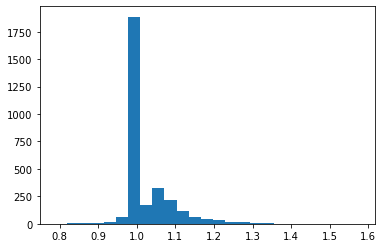

In [17]:
print(np.percentile(data['conf_bound'], [0, 25, 50, 75, 100]))
print("_______________")

print(np.max(data['conf_bound']))
plt.hist(data['conf_bound'], bins = 25)

print("_______________")
print(np.percentile(data['initial_opinion'], [0, 25, 50, 75, 100]))
print("_______________")

#print(np.percentile(data['compound_score',0], [0, 25, 50, 75, 100]))
max_neg = -100
for i in range(2000): 
    temp = data['compound_score'].iloc[i]
    b = temp[0]
    if b > max_neg: 
        max_neg = b
print(max_neg)
print("_______________")


min_neg = 1000
for i in range(2000): 
    temp = data['compound_score'].iloc[i]
    b = temp[0]
    if b < min_neg: 
        min_neg = b
print(min_neg)
print("_______________")

max_pos = -100
for i in range(2000): 
    temp = data['compound_score'].iloc[i]
    b = temp[2]
    if b > max_pos: 
        max_pos = b
print(max_pos)
print("_______________")

min_pos = 1000
for i in range(2000): 
    temp = data['compound_score'].iloc[i]
    b = temp[2]
    if b < min_pos: 
        min_pos = b
print(min_pos)

In [ ]:
#import networkx as nx
#G = nx.DiGraph()

In [ ]:
#generate multiple iterations
#try 10 nodes first
temp = data[data['user_followers_count']<50000]
temp = data[data['retweet_count']<50]
temp = temp.sample(n=10)
temp = temp.set_index('Unnamed: 0')
print(temp.shape)

#temp.to_csv('0704_iter1.csv')

In [ ]:
#50 by 50 adjancency matrix based on graph
def createAdjacencyMatrix(vertices,edges):
    noofvertices=len(vertices)
    adjM=np.zeros((noofvertices, noofvertices), dtype=int)
    while(len(adjM)<noofvertices):
        temp=[]
        for i in range(noofvertices):
            temp.append(0)
        adjM.append(temp)
    for edge in edges:
        i=edge[0]
        j=edge[1]
        if i>=noofvertices or j>=noofvertices or i<0 or j<0:
            print(f"Not a Proper Input in Edge {i},{j}")
        else:
            adjM[i][j]=1
            #adjM[j][i]=1
    #G=nx.Graph()
    #G.add_edges_from(edges)
    #nx.draw_networkx(G)
    #plt.show()
    return adjM



In [ ]:
temp

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
#create an empty graph

#make it directed
#get adjancency matrices of the graphs

G = nx.DiGraph()

random.seed(100)

#temp = data[data['user_followers_count']<50000]
#temp = data[data['retweet_count']<50]
#temp = temp.sample(n=50)
#print(temp.shape)

# Add nodes to the graph with attributes
for index, row in temp.iterrows():
    for i in range(10):
        node_id = index  # Assign a unique node ID based on the row index
        attributes = {key: row[key] for key in row.keys()}
        G.add_node(i, **attributes)

# Create edges randomly based on retweet counts
for node_id in G.nodes:
    retweet_count = G.nodes[node_id]['retweet_count']
    edges = random.sample(G.nodes, retweet_count)  # Randomly select nodes as edges
    for edge in edges:
        if edge != node_id and not G.has_edge(node_id, edge):  # Avoid self-loops and duplicate edges
            G.add_edge(node_id, edge)

#print(G.nodes)
#len(G.edges)
M = createAdjacencyMatrix(G.nodes, G.edges)
#M.shape
# Visualize the graph
#pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
#nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
#plt.show()
  

In [ ]:
print(nx.is_weakly_connected(G))
print(G.nodes[0]['initial_opinion'])  # Access initial confidence bound of the first node

In [ ]:
# Visualize the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_color='red', node_size=10, font_size=8, font_weight='bold')
plt.show()


In [ ]:
nx.is_weakly_connected(G)

In [ ]:
random.seed(11)
new = data[data['user_followers_count']<50000]
new = data[data['retweet_count']<50]
temp = new.sample(n=500)
temp.to_csv('1018_simu1.csv')

df = pd.read_csv('1018_simu1.csv')
G = nx.DiGraph()

# Add nodes to the graph with attributes
for index, row in df.iterrows():
    for i in range(500):
        node_id = index  # Assign a unique node ID based on the row index
        attributes = {key: row[key] for key in row.keys()}
        G.add_node(i, **attributes)

# Create edges randomly based on retweet counts
for node_id in G.nodes:
    retweet_count = G.nodes[node_id]['retweet_count']
    edges = random.sample(G.nodes, retweet_count)  # Randomly select nodes as edges
    for edge in edges:
        if edge != node_id and not G.has_edge(node_id, edge):  # Avoid self-loops and duplicate edges
            G.add_edge(node_id, edge)

#print(G.nodes)
#len(G.edges)
#M = createAdjacencyMatrix(G.nodes, G.edges)
nx.is_weakly_connected(G)

In [ ]:
random.seed(22)
temp = temp.sample(n=10)
temp.to_csv('1107_trial1.csv')

In [ ]:
random.seed(33)
temp = new.sample(n=50)
temp.to_csv('0704_simu3.csv')

In [ ]:
random.seed(44)
temp = new.sample(n=50)
temp.to_csv('0704_simu4.csv')

In [ ]:
random.seed(55)
temp = new.sample(n=50)
temp.to_csv('0704_simu5.csv')

In [ ]:
G = nx.DiGraph()
temp = pd.read_csv('0704_simu1.csv')
# Add nodes to the graph with attributes
for index, row in temp.iterrows():
    for i in range(50):
        node_id = index  # Assign a unique node ID based on the row index
        attributes = {key: row[key] for key in row.keys()}
        G.add_node(i, **attributes)

# Create edges randomly based on retweet counts
for node_id in G.nodes:
    retweet_count = G.nodes[node_id]['retweet_count']
    edges = random.sample(G.nodes, retweet_count)  # Randomly select nodes as edges
    for edge in edges:
        if edge != node_id and not G.has_edge(node_id, edge):  # Avoid self-loops and duplicate edges
            G.add_edge(node_id, edge)

M1 = createAdjacencyMatrix(G.nodes, G.edges)

# Visualize the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
plt.show()


G = nx.DiGraph()
temp = pd.read_csv('0704_simu2.csv')
# Add nodes to the graph with attributes
for index, row in temp.iterrows():
    for i in range(50):
        node_id = index  # Assign a unique node ID based on the row index
        attributes = {key: row[key] for key in row.keys()}
        G.add_node(i, **attributes)

# Create edges randomly based on retweet counts
for node_id in G.nodes:
    retweet_count = G.nodes[node_id]['retweet_count']
    edges = random.sample(G.nodes, retweet_count)  # Randomly select nodes as edges
    for edge in edges:
        if edge != node_id and not G.has_edge(node_id, edge):  # Avoid self-loops and duplicate edges
            G.add_edge(node_id, edge)

M1 = createAdjacencyMatrix(G.nodes, G.edges)

# Visualize the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
plt.show()


G = nx.DiGraph()
temp = pd.read_csv('0704_simu3.csv')
# Add nodes to the graph with attributes
for index, row in temp.iterrows():
    for i in range(50):
        node_id = index  # Assign a unique node ID based on the row index
        attributes = {key: row[key] for key in row.keys()}
        G.add_node(i, **attributes)

# Create edges randomly based on retweet counts
for node_id in G.nodes:
    retweet_count = G.nodes[node_id]['retweet_count']
    edges = random.sample(G.nodes, retweet_count)  # Randomly select nodes as edges
    for edge in edges:
        if edge != node_id and not G.has_edge(node_id, edge):  # Avoid self-loops and duplicate edges
            G.add_edge(node_id, edge)

M1 = createAdjacencyMatrix(G.nodes, G.edges)

# Visualize the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
plt.show()


In [ ]:
G = nx.DiGraph()
temp = pd.read_csv('0704_simu4.csv')
# Add nodes to the graph with attributes
for index, row in temp.iterrows():
    for i in range(50):
        node_id = index  # Assign a unique node ID based on the row index
        attributes = {key: row[key] for key in row.keys()}
        G.add_node(i, **attributes)

# Create edges randomly based on retweet counts
for node_id in G.nodes:
    retweet_count = G.nodes[node_id]['retweet_count']
    edges = random.sample(G.nodes, retweet_count)  # Randomly select nodes as edges
    for edge in edges:
        if edge != node_id and not G.has_edge(node_id, edge):  # Avoid self-loops and duplicate edges
            G.add_edge(node_id, edge)

M1 = createAdjacencyMatrix(G.nodes, G.edges)

# Visualize the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
plt.show()


G = nx.DiGraph()
temp = pd.read_csv('0704_simu5.csv')
# Add nodes to the graph with attributes
for index, row in temp.iterrows():
    for i in range(50):
        node_id = index  # Assign a unique node ID based on the row index
        attributes = {key: row[key] for key in row.keys()}
        G.add_node(i, **attributes)

# Create edges randomly based on retweet counts
for node_id in G.nodes:
    retweet_count = G.nodes[node_id]['retweet_count']
    edges = random.sample(G.nodes, retweet_count)  # Randomly select nodes as edges
    for edge in edges:
        if edge != node_id and not G.has_edge(node_id, edge):  # Avoid self-loops and duplicate edges
            G.add_edge(node_id, edge)

M1 = createAdjacencyMatrix(G.nodes, G.edges)

# Visualize the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
plt.show()
